In [17]:
import pandas as pd
import numpy as np
import os

def load_breast_cancer_data(filename='wdbc.data', split_ratio=0.8):
    print(f"Loading {filename}...")
    if not os.path.exists(filename):
        raise FileNotFoundError(f"File '{filename}' not found. Please download it and place it in this folder.")

    # Load Data (No header in this dataset)
    # Col 0: ID, Col 1: Diagnosis (M/B), Cols 2-31: Features
    df = pd.read_csv(filename, header=None)
    
    # Extract only the 30 numerical features (Columns 2 to 31)
    X = df.iloc[:, 2:].values.astype(np.float32)
    
    # --- CRITICAL CHANGE: Min-Max Normalization ---
    # We must squash all values to [0, 1] for the Sigmoid output layer to work
    min_val = np.min(X, axis=0)
    max_val = np.max(X, axis=0)
    X = (X - min_val) / (max_val - min_val + 1e-8) # +1e-8 avoids division by zero

    # Shuffle
    indices = np.random.permutation(X.shape[0])
    X = X[indices]
    
    # Split
    split_idx = int(X.shape[0] * split_ratio)
    X_train = X[:split_idx]
    X_test  = X[split_idx:]
    
    return X_train, X_test

# Load
try:
    X_train, X_test = load_breast_cancer_data()
    print(f"Train Shape: {X_train.shape}") # Should be (455, 30)
    print(f"Test Shape:  {X_test.shape}")  # Should be (114, 30)
except Exception as e:
    print(f"Error: {e}")

Loading wdbc.data...
Train Shape: (455, 30)
Test Shape:  (114, 30)


In [18]:
#layer implementations
class Layer:
    def __init__(self, input_dim, output_dim,activation):
        # He Initialization
        scale = np.sqrt(2.0 / input_dim)
        self.weights = np.random.randn(input_dim, output_dim) * scale
        self.bias = np.zeros((1, output_dim))
        self.activation=activation
        #parameters for forward pass
        self.x = None
        self.z = None
        self.y = None
        #parameters for backward pass
        self.dW = None
        self.db = None
        

    def forward(self, x):
        self.x = x
        #z = Wx + b
        #y=activation(z)
        self.z=np.dot(x, self.weights) + self.bias
        if self.activation == 'relu':
            self.y = np.maximum(0, self.z)
        elif self.activation == 'sigmoid':
            self.y = 1 / (1 + np.exp(-self.z))
        elif self.activation == 'tanh':
            self.y = np.tanh(self.z)
        return self.y
        
        
    def backward(self, d_out):
        #dL/dZ=dL/dY*activation(z)
        if self.activation == 'relu':
            # Derivative is 1 if z > 0, else 0
            dz = d_out * (self.z > 0) 
            
        elif self.activation == 'sigmoid':
            # Derivative is a * (1 - a)
            dz = d_out * (self.y * (1 - self.y))
            
        elif self.activation == 'tanh':
            # Derivative is 1 - a^2
            dz = d_out * (1 - self.y**2)

        #dL/dW=dL/dY*dY/dW-->rate of change of loss wrt Y is X(y = Wx + b)
        #dL/dW=XT*dY/dW
        self.dW = np.dot(self.x.T, dz) # Use self.x (the input to this layer)
        # db = sum(dZ)
        self.db = np.sum(dz, axis=0, keepdims=True)
        # dX = dZ * W.T
        return np.dot(dz, self.weights.T) # this is the previous layer's d_out
    



In [19]:
class Autoencoder:
    def __init__(self,input_dim,bottleneck_dim):
        self.layers = []
        # Encoder: 30 -> 20 -> 10
        self.layers.append(Layer(input_dim, 20, 'relu'))     
        self.layers.append(Layer(20, 10, 'relu'))            
        
        # Bottleneck: 10 -> 5
        self.layers.append(Layer(10, bottleneck_dim, 'relu')) 
        
        # Decoder: 5 -> 10 -> 20 -> 30
        self.layers.append(Layer(bottleneck_dim, 10, 'relu'))  
        self.layers.append(Layer(10, 20, 'relu'))             
        self.layers.append(Layer(20, input_dim, 'sigmoid')) 
    
    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer.forward(out)
        return out

    def backward(self, loss_grad):
        grad = loss_grad
        for layer in reversed(self.layers):
            grad = layer.backward(grad)



In [20]:
#compute loss function and L2 regularization
def get_loss_and_L2Reg(Y,T):
    N = T.shape[0]
    # MSE Loss formula
    loss = np.mean((Y - T) ** 2)
    # Derivative of MSE: 2/N * (Prediction - Target)
    loss_grad = (2/N) * (Y - T)
    return loss, loss_grad

In [21]:
#Optimization
def optimization(model,lr,lambda_l2):
    #full equation:Wnew=Wold-lr*(dw+lambda*Wold)
    for layer in model.layers:
        #lambda*Woold
        weight_decay = lambda_l2 * layer.weights
        #lr*(dw+lambda*Wold)
        layer.weights -= lr * (layer.dW + weight_decay)
        #Wnew=Wold-lr*(dw+lambda*Wold)
        layer.bias-= lr * layer.db

In [22]:
#Get learning rate
def get_lr(initial_lr, epoch):
    # Decay the LR by 50% every 10 epochs
    drop_factor = 0.5
    epochs_drop = 10.0
    # Formula: lr * (0.5 ^ floor(epoch / 10))
    lr = initial_lr * math.pow(drop_factor, math.floor((1 + epoch) / epochs_drop))
    return lr

In [23]:
#Final training loop
def train(model, X_train, epochs, batch_size, initial_lr, lambda_l2):
    print(f"Starting training on {X_train.shape[0]} samples...")
    loss_history = []
    for epoch in range(epochs):
        # 1. Update Learning Rate
        current_lr = get_lr(initial_lr, epoch)
        
        # 2. Shuffle Data
        indices = np.random.permutation(X_train.shape[0])
        X_shuffled = X_train[indices]
        
        epoch_loss = 0
        num_batches = 0
        
        # 3. Mini-Batch Loop
        for i in range(0, X_train.shape[0], batch_size):
            # Get Batch
            x_batch = X_shuffled[i : i + batch_size]
            
            # A. Forward Pass
            # Autoencoder Input == Target
            y_pred = model.forward(x_batch)
            
            # B. Compute Loss
            loss, loss_grad = get_loss_and_L2Reg(y_pred, x_batch)
            epoch_loss += loss
            num_batches += 1
            
            # C. Backward Pass
            model.backward(loss_grad)
            
            # D. Optimization (Update Weights)
            optimization(model, current_lr, lambda_l2)
            
        # Print progress every epoch
        avg_loss = epoch_loss / num_batches
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | LR: {current_lr:.5f}")
    return loss_history

In [24]:
model = Autoencoder(input_dim=30, bottleneck_dim=5)
loss_history = train(model, X_train, epochs=200, batch_size=16, initial_lr=0.01, lambda_l2=0.0)

Starting training on 455 samples...
Epoch 1/200 | Loss: 0.0925 | LR: 0.01000
Epoch 2/200 | Loss: 0.0838 | LR: 0.01000
Epoch 3/200 | Loss: 0.0754 | LR: 0.01000
Epoch 4/200 | Loss: 0.0661 | LR: 0.01000
Epoch 5/200 | Loss: 0.0563 | LR: 0.01000
Epoch 6/200 | Loss: 0.0467 | LR: 0.01000
Epoch 7/200 | Loss: 0.0381 | LR: 0.01000
Epoch 8/200 | Loss: 0.0318 | LR: 0.01000
Epoch 9/200 | Loss: 0.0277 | LR: 0.01000
Epoch 10/200 | Loss: 0.0252 | LR: 0.00500
Epoch 11/200 | Loss: 0.0244 | LR: 0.00500
Epoch 12/200 | Loss: 0.0236 | LR: 0.00500
Epoch 13/200 | Loss: 0.0232 | LR: 0.00500
Epoch 14/200 | Loss: 0.0227 | LR: 0.00500
Epoch 15/200 | Loss: 0.0224 | LR: 0.00500
Epoch 16/200 | Loss: 0.0227 | LR: 0.00500
Epoch 17/200 | Loss: 0.0219 | LR: 0.00500
Epoch 18/200 | Loss: 0.0216 | LR: 0.00500
Epoch 19/200 | Loss: 0.0216 | LR: 0.00500
Epoch 20/200 | Loss: 0.0215 | LR: 0.00250
Epoch 21/200 | Loss: 0.0215 | LR: 0.00250
Epoch 22/200 | Loss: 0.0215 | LR: 0.00250
Epoch 23/200 | Loss: 0.0217 | LR: 0.00250
Epoch 2

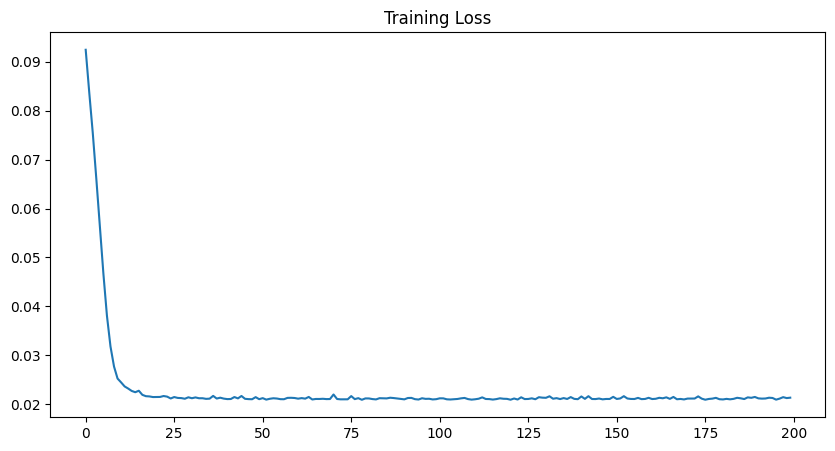

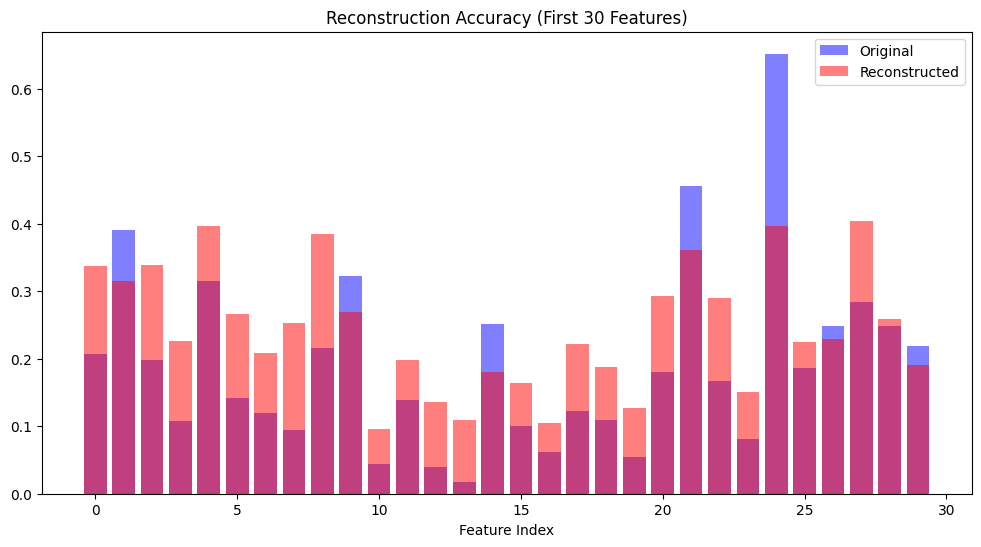

In [25]:
# 3. Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title('Training Loss')
plt.show()

# 4. New Visualization: Bar Chart Comparison
sample_input = X_test[0:1] # Take first test sample
sample_output = model.forward(sample_input)

features = range(30)
plt.figure(figsize=(12, 6))
plt.bar(features, sample_input[0], alpha=0.5, label='Original', color='blue')
plt.bar(features, sample_output[0], alpha=0.5, label='Reconstructed', color='red')
plt.title("Reconstruction Accuracy (First 30 Features)")
plt.xlabel("Feature Index")
plt.legend()
plt.show()